# Creating Architecture and loading data

In [2]:
!pip install plot_keras_history
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as K
import os
import cv2
from tensorflow.keras.applications import EfficientNetB0
from plot_keras_history import plot_history
from tensorflow.keras.layers import Flatten, Dropout, Dense, AveragePooling2D, BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.29-py3-none-any.whl size=8613 sha256=2c4e3afbb8e9b1667318ea3ee11a802414f13918f605ba3d67a5e015525243b4
  Stored in directory: /root/.cache/pip/wheels/9e/2e/42/17cb826d143226e4d081aa33d3a9b9a90f234dfcf409824b87
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=350d96fb3c26b45f57c9a735f8efab28155c9024653bf3fb58ef87ed39de9933
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4585 sha256=0d42b961645847adb1e1f46d95d292ebe1320750d8561e080fbbf3d6419fab01
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json
Mounted at /content/drive


In [2]:
BATCH_SIZE=64

In [3]:
def create_model():
  #Defining an architecture based on EfficientNetB0

  # weights = 'imagenet' --> We use ImageNet weigths as default
  # include_top = False --> We truncate the last layer in order to have only three neurons (one per class) 
  
  baseModel = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
  baseModel.trainable=True

  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dropout(0.6)(headModel)

  # Output layer
  output = Dense(units=3, activation='softmax')(headModel)

  network = K.Model(inputs= baseModel.input, outputs= output)

  #We decided to use accuracy, auroc and auprc as metrics
  network.compile(loss="categorical_crossentropy", optimizer=K.optimizers.Adam(learning_rate=0.001), metrics=['accuracy',
                                                                          K.metrics.AUC(curve="ROC", name="auroc"), 
                                                                          K.metrics.AUC(curve="PR", name="auprc"),])
  return network

In [ ]:
network = create_model()
network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
#LOADING DATA

PCT_PATH='/content/drive/MyDrive/nCT_pCT_NiCT/pCT/'
NICT_PATH='/content/drive/MyDrive/nCT_pCT_NiCT/NiCT/'
NCT_PATH='/content/drive/MyDrive/nCT_pCT_NiCT/nCT/'

X_all=[]

for i,path in enumerate(os.listdir(PCT_PATH)):
  image=cv2.imread(PCT_PATH+path)
  X_all.append(image)

for i,path in enumerate(os.listdir(NICT_PATH)):
  image=cv2.imread(NICT_PATH+path)
  X_all.append(image)

for i,path in enumerate(os.listdir(NCT_PATH)):
  image=cv2.imread(NCT_PATH+path)
  X_all.append(image)

X_all=np.array(X_all)

#Saving the array in npy file for loading data faster
np.save('/content/drive/MyDrive/X_all.npy', X_all)

In [ ]:
#Use this if you already saved 
X_all = np.load('/content/drive/MyDrive/X_all.npy')
X_all.shape

In [4]:
Y_all=[]

PCT_PATH='/content/drive/MyDrive/nCT_pCT_NiCT/pCT/'
NICT_PATH='/content/drive/MyDrive/nCT_pCT_NiCT/NiCT/'
NCT_PATH='/content/drive/MyDrive/nCT_pCT_NiCT/nCT/'

Y_all.extend([0]*len(os.listdir(PCT_PATH)))
Y_all.extend([1]*len(os.listdir(NICT_PATH)))
Y_all.extend([2]*len(os.listdir(NCT_PATH)))

Y_all=np.asarray(Y_all)
print(Y_all)

[0 0 0 ... 2 2 2]


# Train test split and data augmentation

In [ ]:
#TRAIN TEST VAL SPLIT
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_all, Y_all,
                                                    test_size=0.1,
                                                    stratify=Y_all)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val,
                                                  test_size=0.1,
                                                  stratify=Y_train_val)

Y_train = K.utils.to_categorical(Y_train)
Y_val = K.utils.to_categorical(Y_val)
Y_test = K.utils.to_categorical(Y_test)

In [ ]:
#AUGMENTATION

from tensorflow.python.keras.utils.data_utils import Sequence

class MySequence(Sequence):

    def __init__(self, batch_size, augmentations):
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

import cv2
from albumentations import (
    Compose, HorizontalFlip, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
])

AUGMENTATIONS_VAL = Compose([])

AUGMENTATIONS_TEST = Compose([])

In [ ]:
# Train data
train_data = MySequence( BATCH_SIZE, augmentations=AUGMENTATIONS_TRAIN)
train_data.x = X_train
train_data.y = Y_train

# Validation data
validation_data = MySequence( BATCH_SIZE, augmentations=AUGMENTATIONS_VAL)
validation_data.x = X_val
validation_data.y = Y_val

# Test data
test_data = MySequence( 1, augmentations=AUGMENTATIONS_TEST)
test_data.x = X_test
test_data.y = Y_test

# Training and split results

Epoch 1/100
250/250 [==============================] - 200s 629ms/step - loss: 0.2443 - accuracy: 0.9096 - auroc: 0.9767 - auprc: 0.9598 - val_loss: 0.0901 - val_accuracy: 0.9723 - val_auroc: 0.9963 - val_auprc: 0.9931
Epoch 2/100
250/250 [==============================] - 155s 620ms/step - loss: 0.0731 - accuracy: 0.9760 - auroc: 0.9981 - auprc: 0.9964 - val_loss: 0.0644 - val_accuracy: 0.9808 - val_auroc: 0.9988 - val_auprc: 0.9979
Epoch 3/100
250/250 [==============================] - 154s 616ms/step - loss: 0.0489 - accuracy: 0.9844 - auroc: 0.9985 - auprc: 0.9971 - val_loss: 0.0707 - val_accuracy: 0.9853 - val_auroc: 0.9970 - val_auprc: 0.9942
Epoch 4/100
250/250 [==============================] - 154s 614ms/step - loss: 0.0320 - accuracy: 0.9895 - auroc: 0.9991 - auprc: 0.9983 - val_loss: 0.0202 - val_accuracy: 0.9927 - val_auroc: 0.9999 - val_auprc: 0.9998
Epoch 5/100
250/250 [==============================] - 154s 617ms/step - loss: 0.0196 - accuracy: 0.9928 - auroc: 0.9998 - a

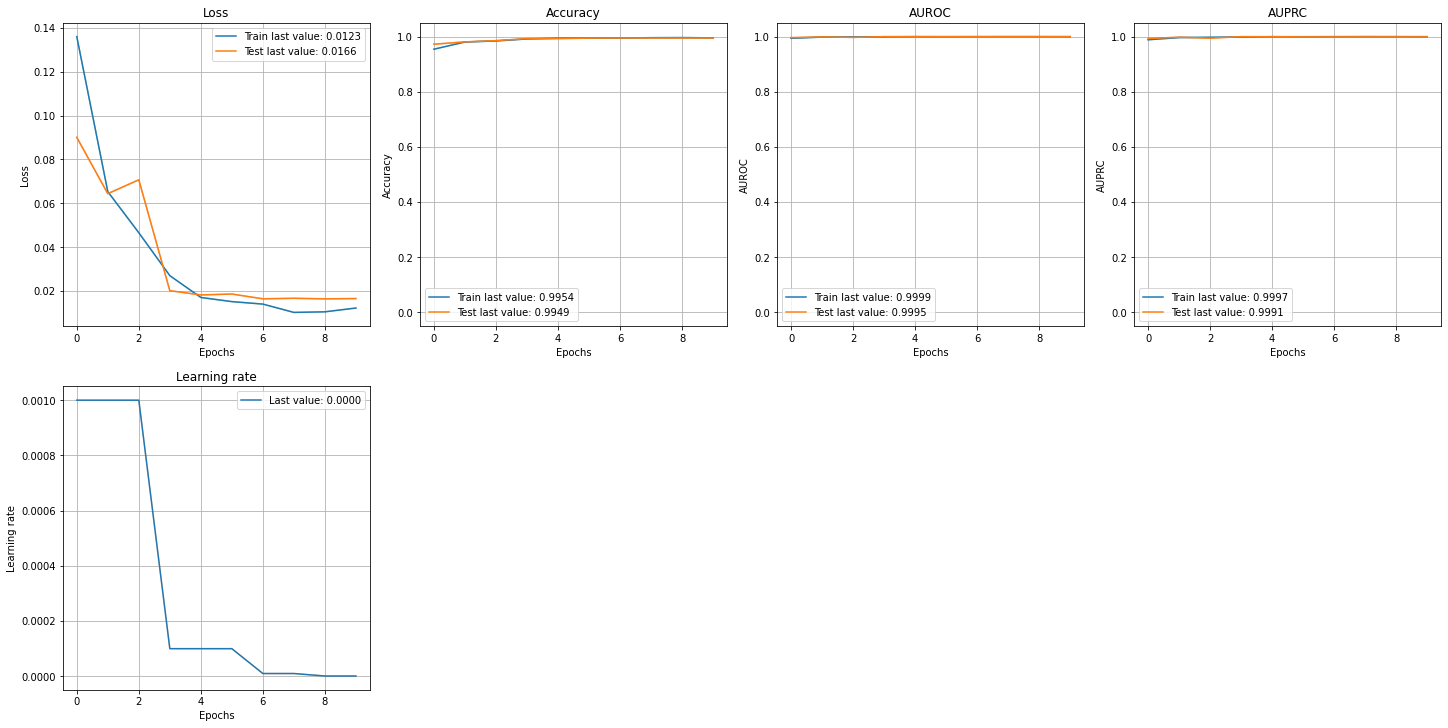

In [ ]:
#Training the model
training = network.fit( train_data,
                        epochs=100, 
                        validation_data=validation_data, 
                        callbacks= [
                                      K.callbacks.EarlyStopping(
                                          monitor="accuracy",
                                          min_delta=0.00001,
                                          patience=1,
                                          restore_best_weights=True
                                      ),
                                      K.callbacks.ReduceLROnPlateau(
                                          monitor = 'val_loss',
                                          facotr = 0.3,
                                          patience = 1,
                                          min_lr = 0.000001
                                      )]
                        )

plot_history(training.history)

network.save('/content/drive/My Drive/Model_saved/CNN_images_onlybody_efficientnetb0.h5')

In [ ]:
network = K.models.load_model('/content/drive/My Drive/Model_saved/CNN_images_onlybody_efficientnetb0.h5')

In [ ]:
predictions= network.predict( test_data )

In [ ]:
network.evaluate(test_data)

1969/1969 [==============================] - 26s 13ms/step - loss: 0.0242 - accuracy: 0.9924 - auroc: 0.9993 - auprc: 0.9988


[0.02423613704741001,
 0.9923819303512573,
 0.9992668032646179,
 0.9988413453102112]

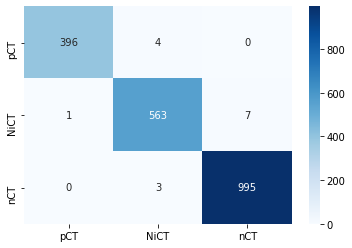

In [ ]:
#Confusion matrix on test data
y_pred = np.argmax(predictions, axis=1)
y_true= np.argmax(Y_test, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sn

categories = ['pCT', 'NiCT', 'nCT']

np.set_printoptions(precision=2)
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
sn.heatmap(cm, annot=True,cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories)

# 10-fold Cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
skf= StratifiedKFold(n_splits=10, shuffle=False)

#AUGMENTATION
# Train data
train_data = MySequence( BATCH_SIZE, augmentations=AUGMENTATIONS_TRAIN)
# Validation data
validation_data = MySequence( BATCH_SIZE, augmentations=AUGMENTATIONS_VAL)
# Test data
test_data = MySequence( 1, augmentations=AUGMENTATIONS_TEST)

for train_indexes, test_indexes in skf.split(X_all, Y_all):
  print('NUOVA ITERAZIONE ')
  #Data augmentation
  print(train_indexes)
  X_train_val= X_all[train_indexes]
  Y_train_val=Y_all[train_indexes]
  X_test= X_all[test_indexes]
  Y_test=Y_all[test_indexes]
  #We split again data to keep 10% for validation
  X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, stratify=Y_train_val)

  Y_train = K.utils.to_categorical(Y_train)
  Y_val = K.utils.to_categorical(Y_val)
  Y_test = K.utils.to_categorical(Y_test)

  train_data.x=X_train
  train_data.y=Y_train
  validation_data.x=X_val
  validation_data.y=Y_val
  test_data.x=X_test
  test_data.y=Y_test
  
  #Creating a new model for the current iteration
  model=create_model()

  #Fitting the model
  training = model.fit( train_data,
                          epochs=100, 
                          validation_data=validation_data, 
                          callbacks= [
                                      K.callbacks.EarlyStopping(
                                          monitor="accuracy",
                                          min_delta=0.00001,
                                          patience=1,
                                          restore_best_weights=True
                                      ),
                                      K.callbacks.ReduceLROnPlateau(
                                          monitor = 'val_loss',
                                          facotr = 0.3,
                                          patience = 1,
                                          min_lr = 0.000001
                                      )])
  #Making prediction on test data for current iteration
  predictions= model.predict( test_data )
  #Saving results on a file
  with open('Y_all_pred.txt', mode='a') as f:
    for i,pred in enumerate(predictions):
      f.write( str(test_indexes[i])+','+str(pred)+'\n')

  del predictions
  del X_train_val
  del Y_train_val
  del X_test
  del Y_test
  del X_train
  del Y_train
  del X_val
  del Y_val
  import gc
  gc.collect()

NUOVA ITERAZIONE 
[  401   402   403 ... 19682 19683 19684]
Epoch 1/100
250/250 [==============================] - 176s 534ms/step - loss: 0.3924 - accuracy: 0.8567 - auroc: 0.9540 - auprc: 0.9196 - val_loss: 1.8116 - val_accuracy: 0.2901 - val_auroc: 0.5669 - val_auprc: 0.3579
Epoch 2/100
250/250 [==============================] - 131s 522ms/step - loss: 0.1812 - accuracy: 0.9438 - auroc: 0.9896 - auprc: 0.9811 - val_loss: 2.0334 - val_accuracy: 0.2963 - val_auroc: 0.6131 - val_auprc: 0.4597
Epoch 3/100
250/250 [==============================] - 131s 525ms/step - loss: 0.1245 - accuracy: 0.9609 - auroc: 0.9943 - auprc: 0.9898 - val_loss: 0.1987 - val_accuracy: 0.9560 - val_auroc: 0.9931 - val_auprc: 0.9880
Epoch 4/100
250/250 [==============================] - 132s 528ms/step - loss: 0.0916 - accuracy: 0.9684 - auroc: 0.9970 - auprc: 0.9943 - val_loss: 0.8139 - val_accuracy: 0.7302 - val_auroc: 0.8882 - val_auprc: 0.7881
Epoch 5/100
250/250 [==============================] - 130s 521m

In [7]:
import numpy as np
Y_pCT_pred = np.array([-1.0]*19685)
Y_NiCT_pred = np.array([-1.0]*19685)
Y_nCT_pred = np.array([-1.0]*19685)
Y_all_pred = np.array([-1]*19685)

i=0
with open('/content/drive/MyDrive/Y_all_pred.txt') as f:
  for x in f:
    index, prediction = x.split(',')
    pred=[]
    prediction=" ".join(prediction.split())
    pred.append(float(prediction.split(' ')[0][1:]))
    pred.append(float(prediction.split(' ')[1][:]))
    pred.append(float(prediction.split(' ')[2][:-1]))

    
    if Y_pCT_pred[int(index)] != -1.0:
      i+=1
    else:
      Y_pCT_pred[int(index)] = float(pred[0])
      Y_NiCT_pred[int(index)] = float(pred[1])
      Y_nCT_pred[int(index)] = float(pred[2])
      Y_all_pred[int(index)] = np.argmax(pred)
np.save('/content/drive/MyDrive/Y_all_pred.npy', Y_all_pred)

In [122]:
import numpy as np
Y_all_pred = np.load('/content/drive/MyDrive/Y_all_pred.npy')

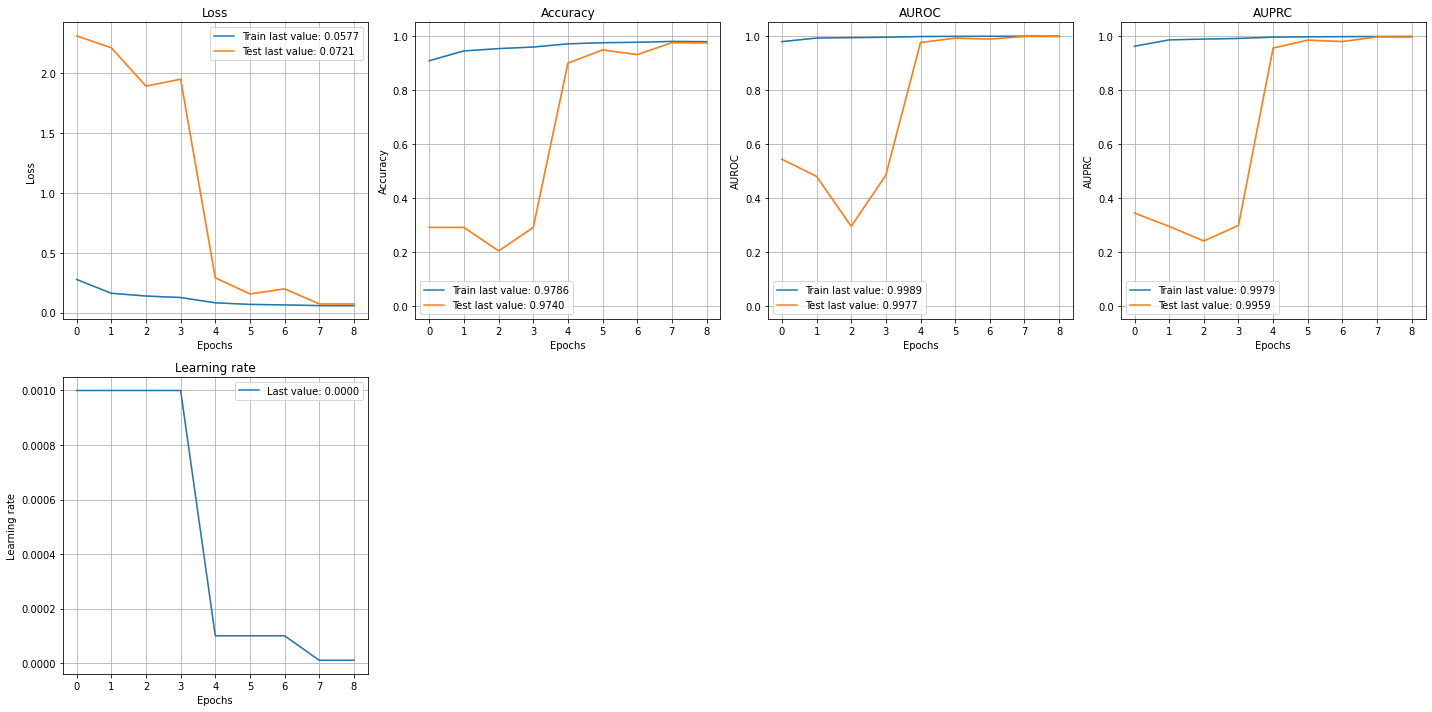

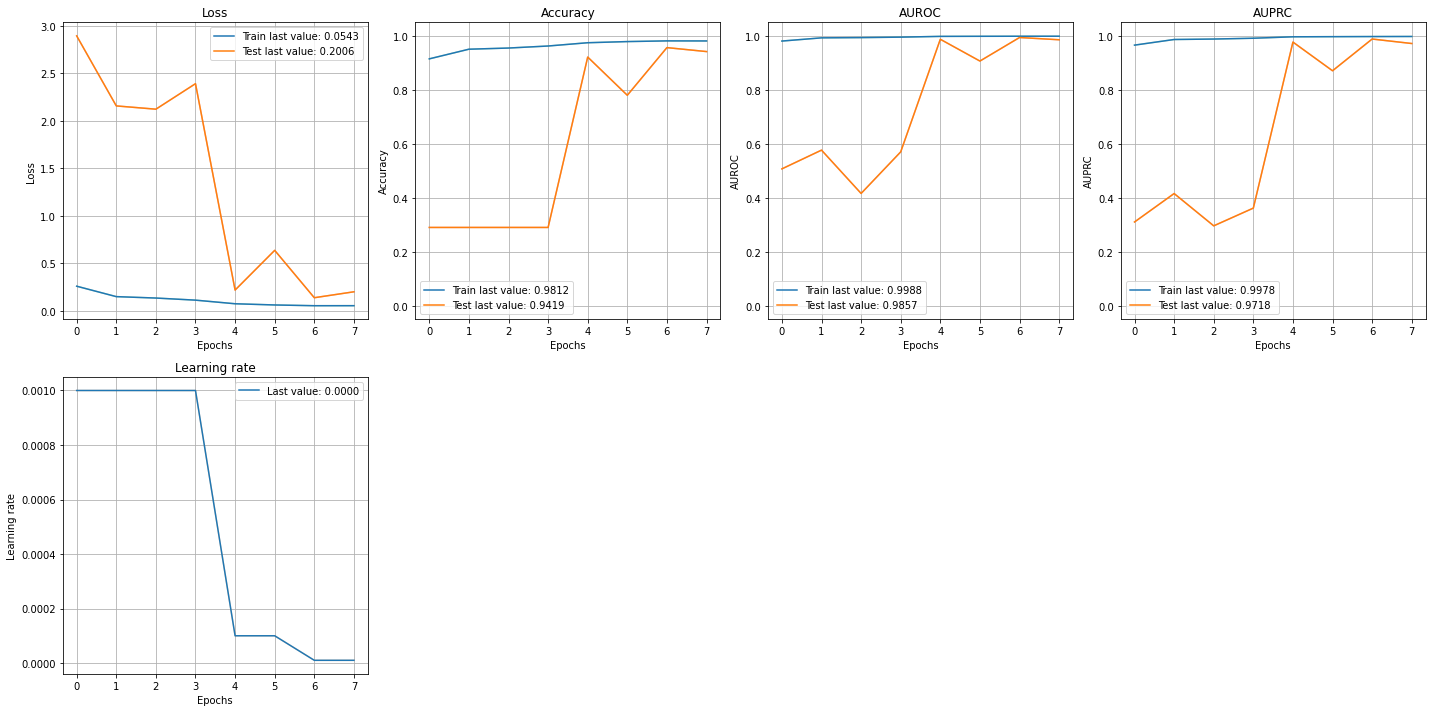

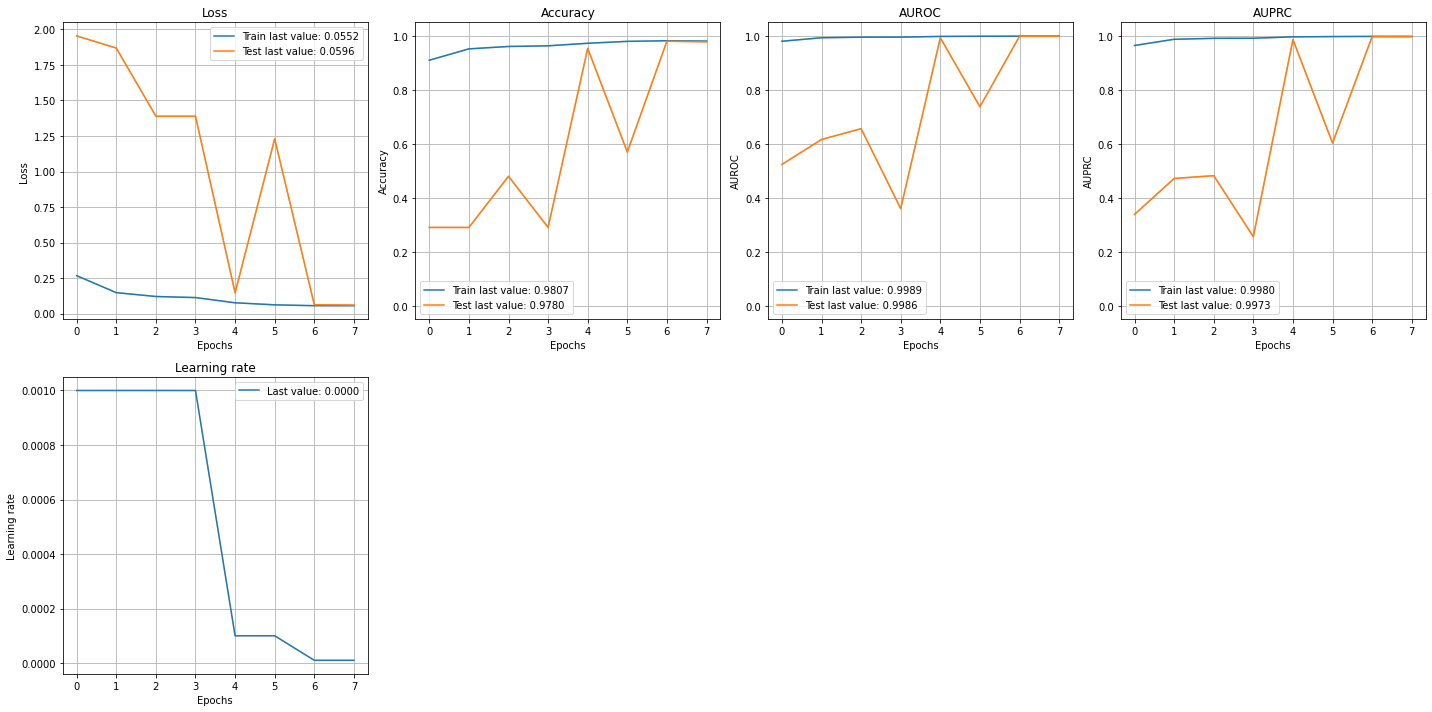

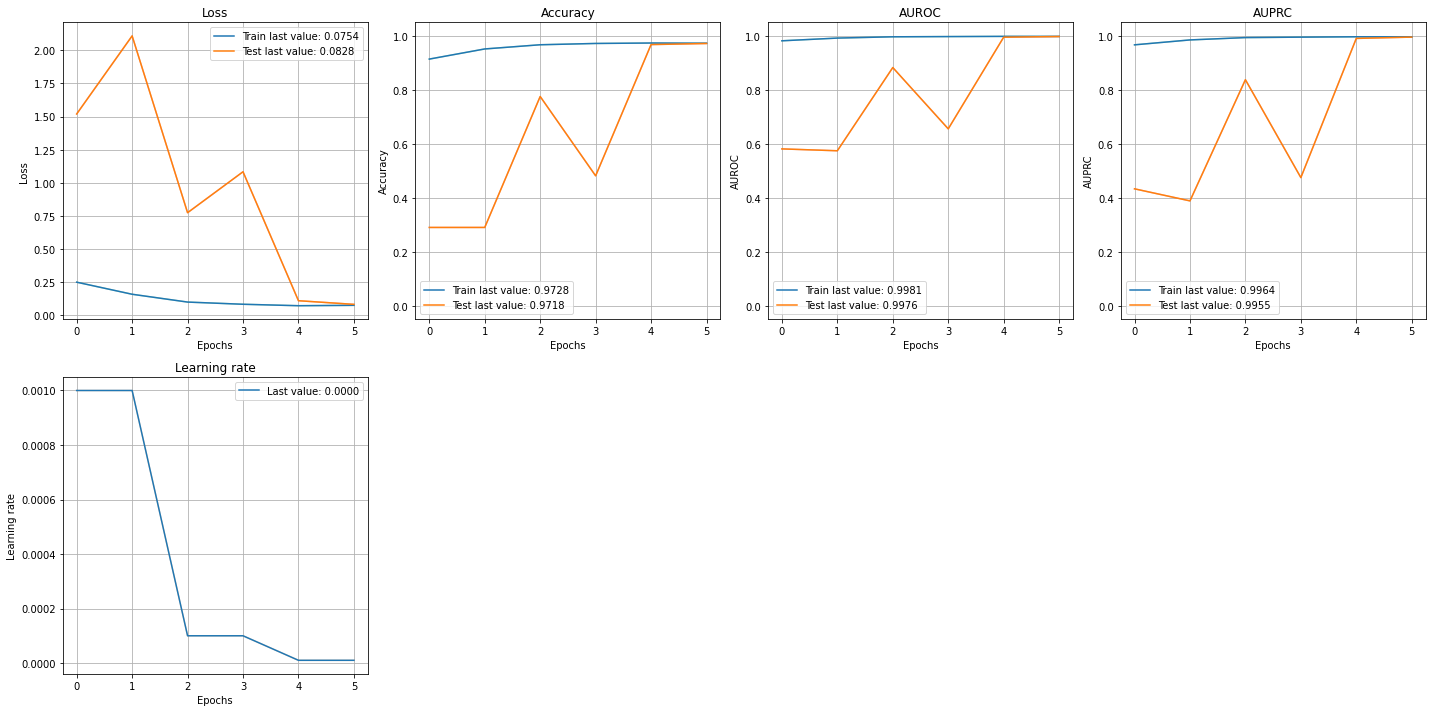

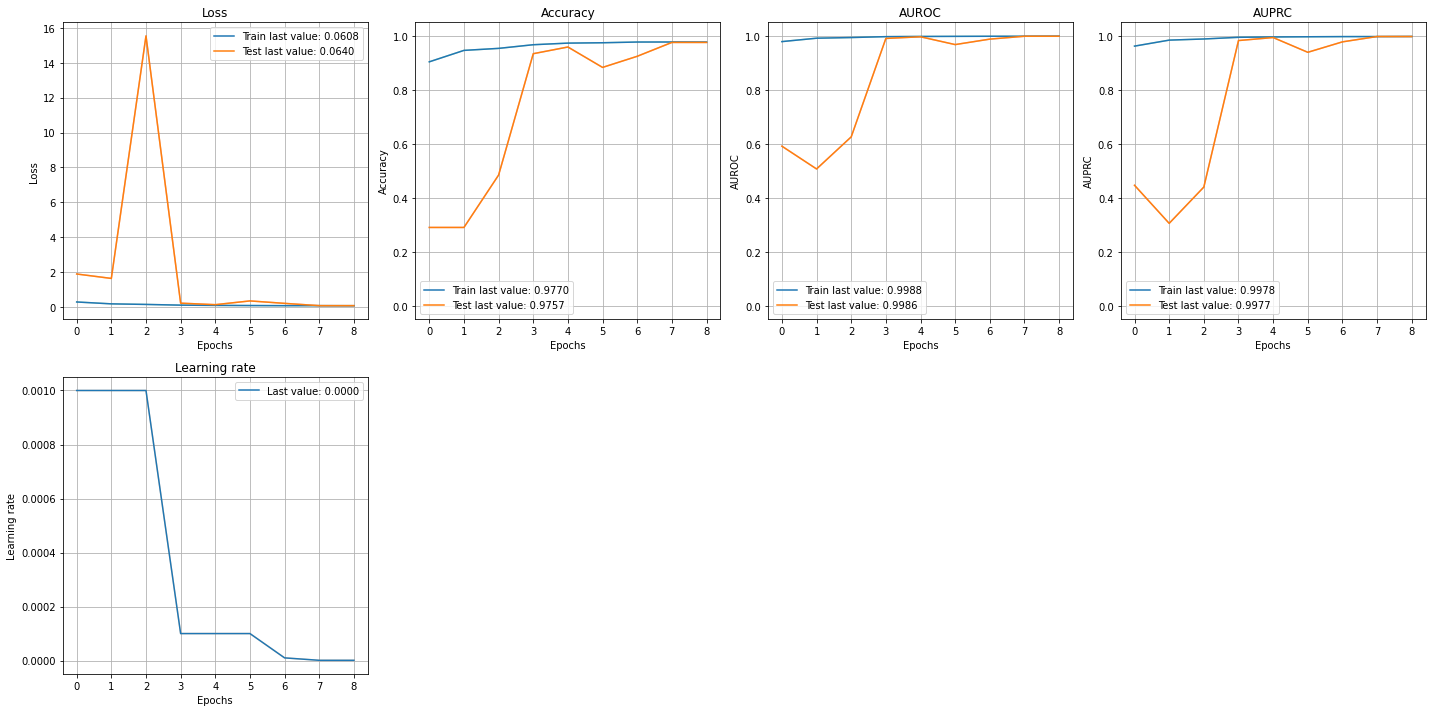

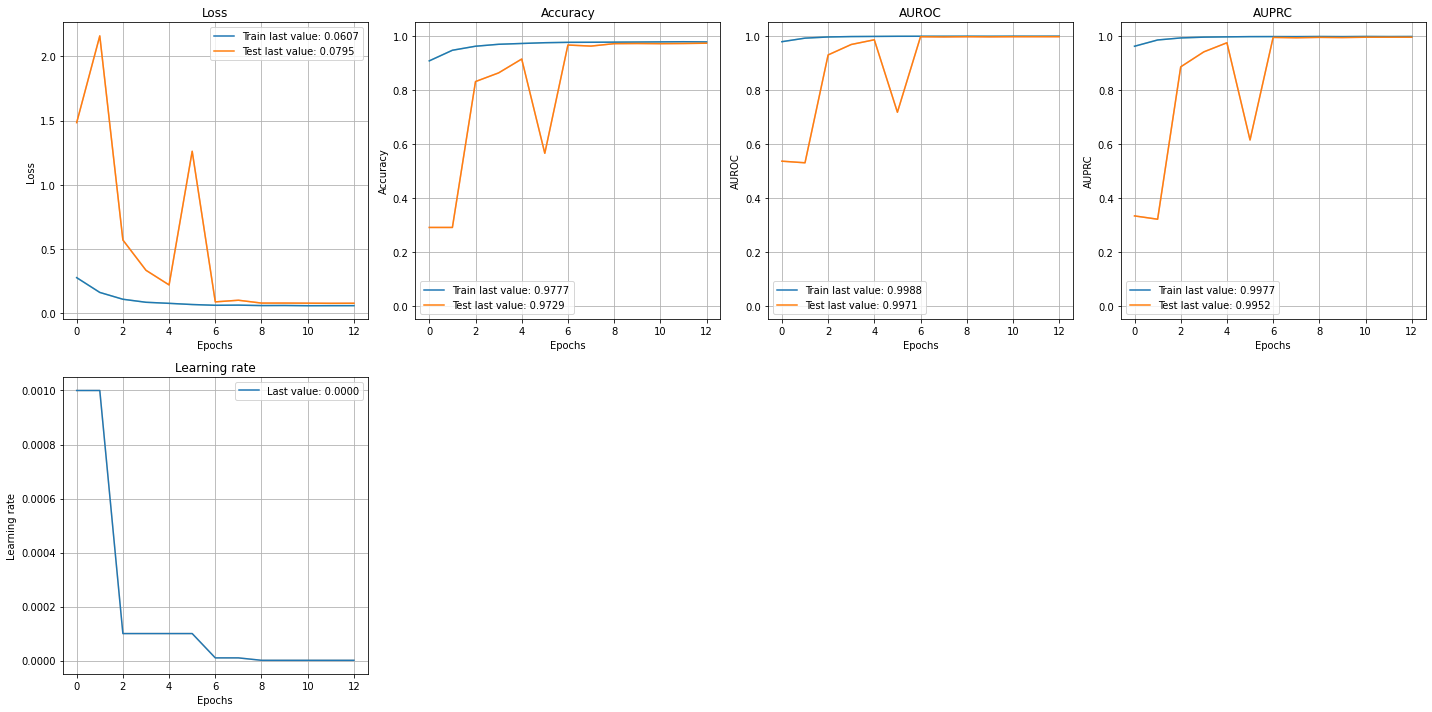

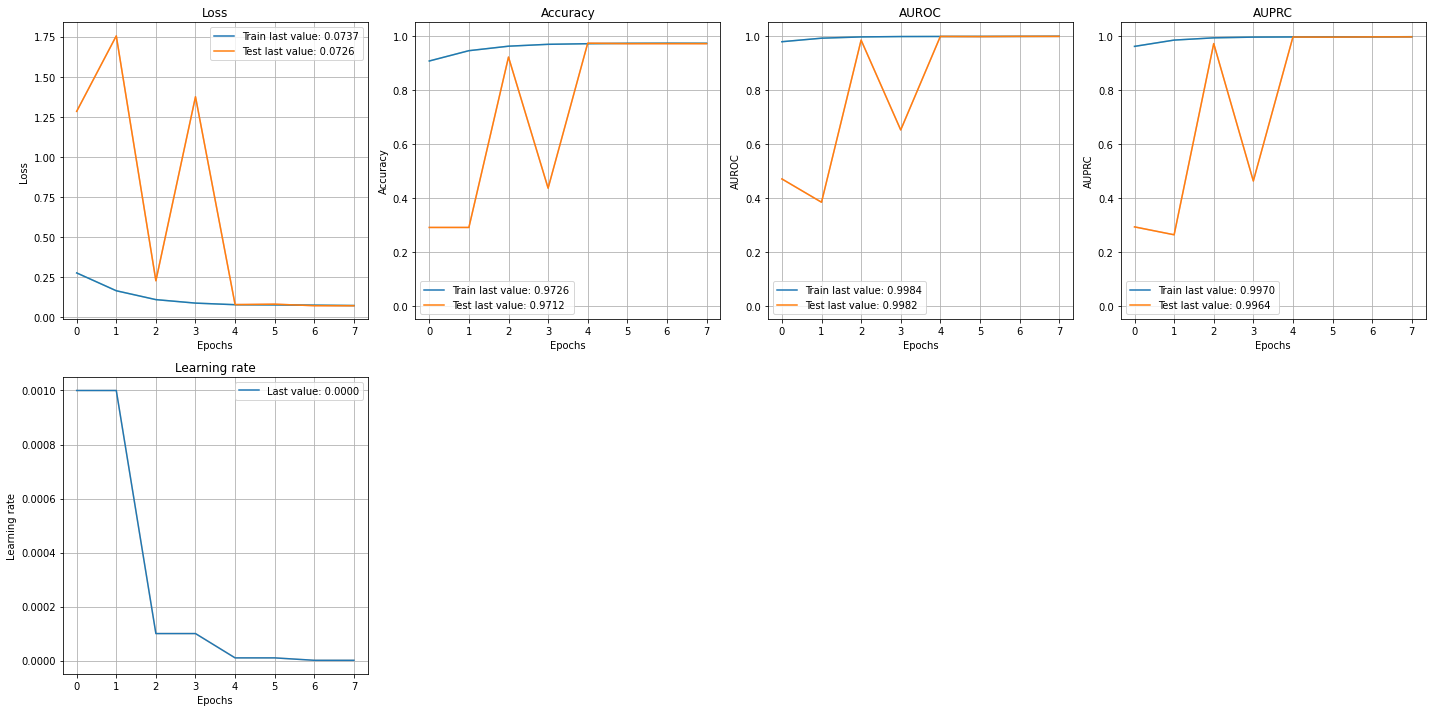

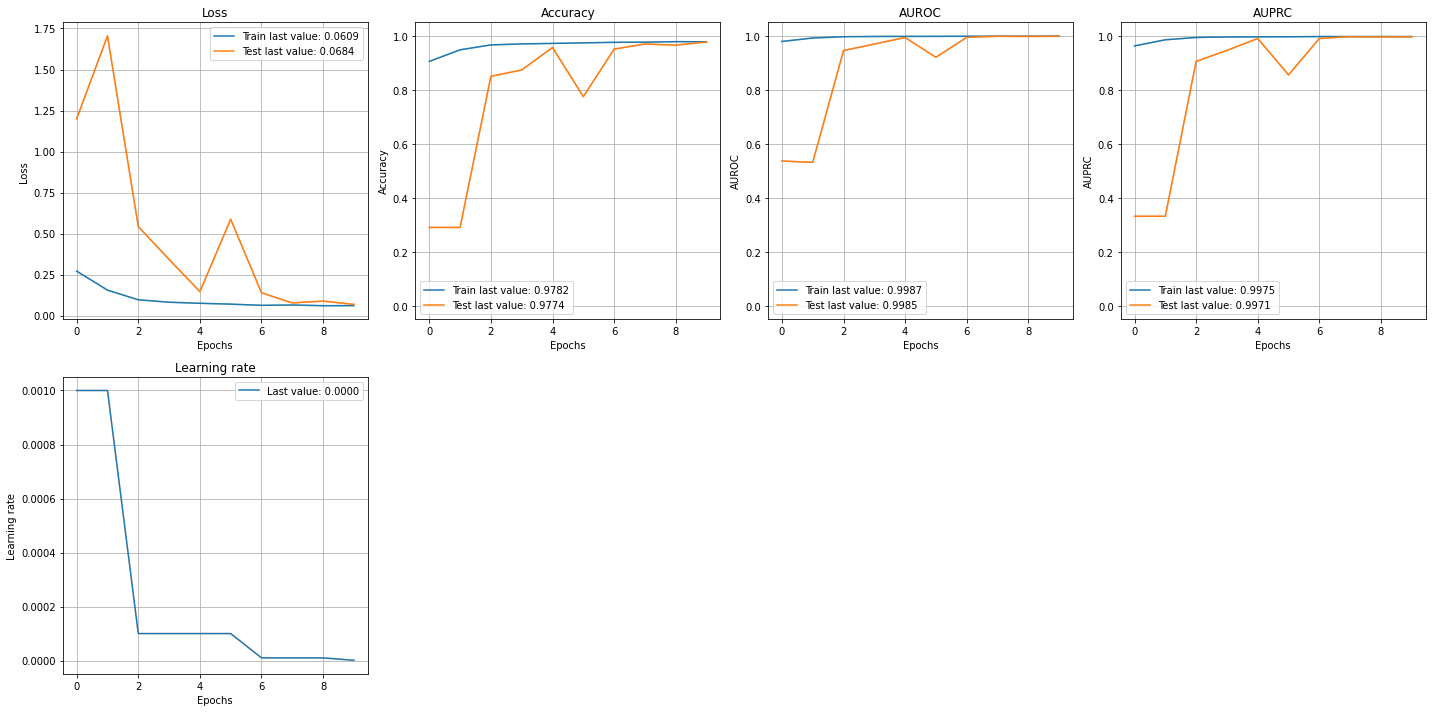

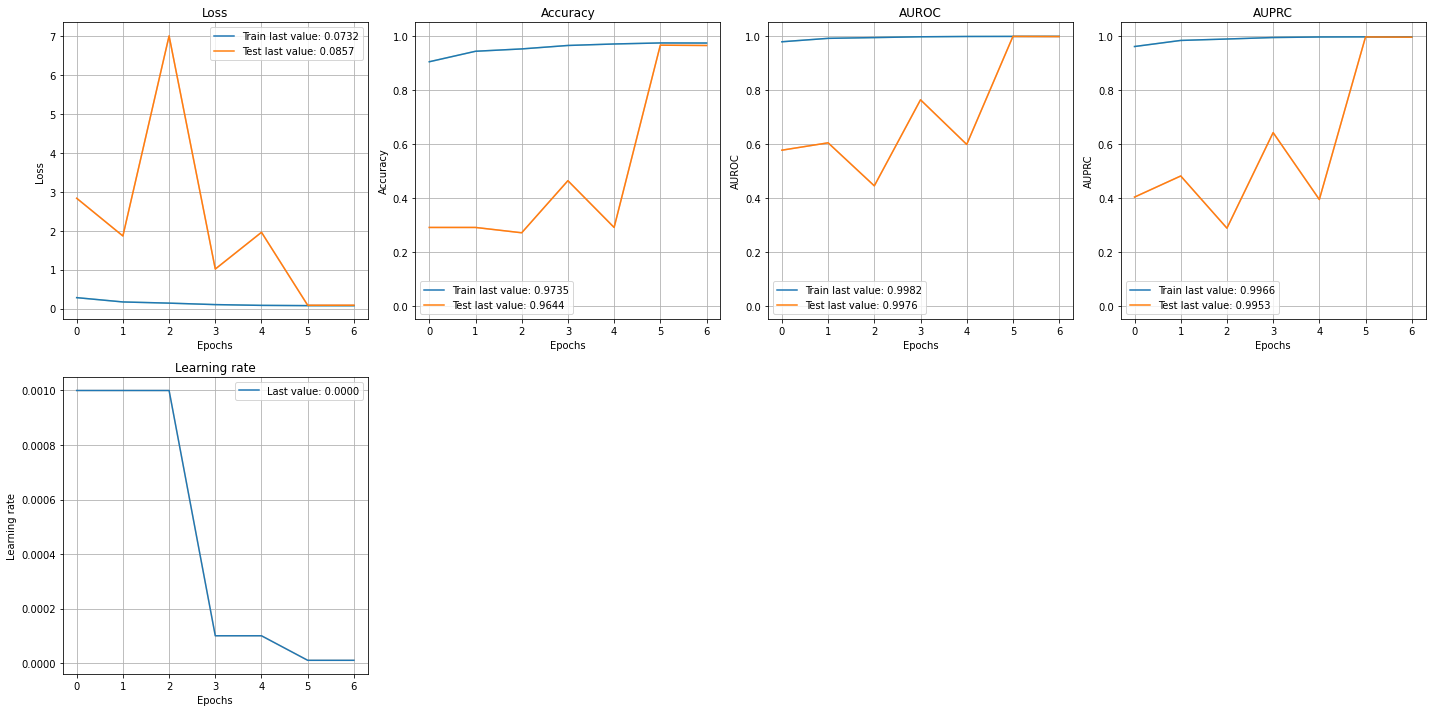

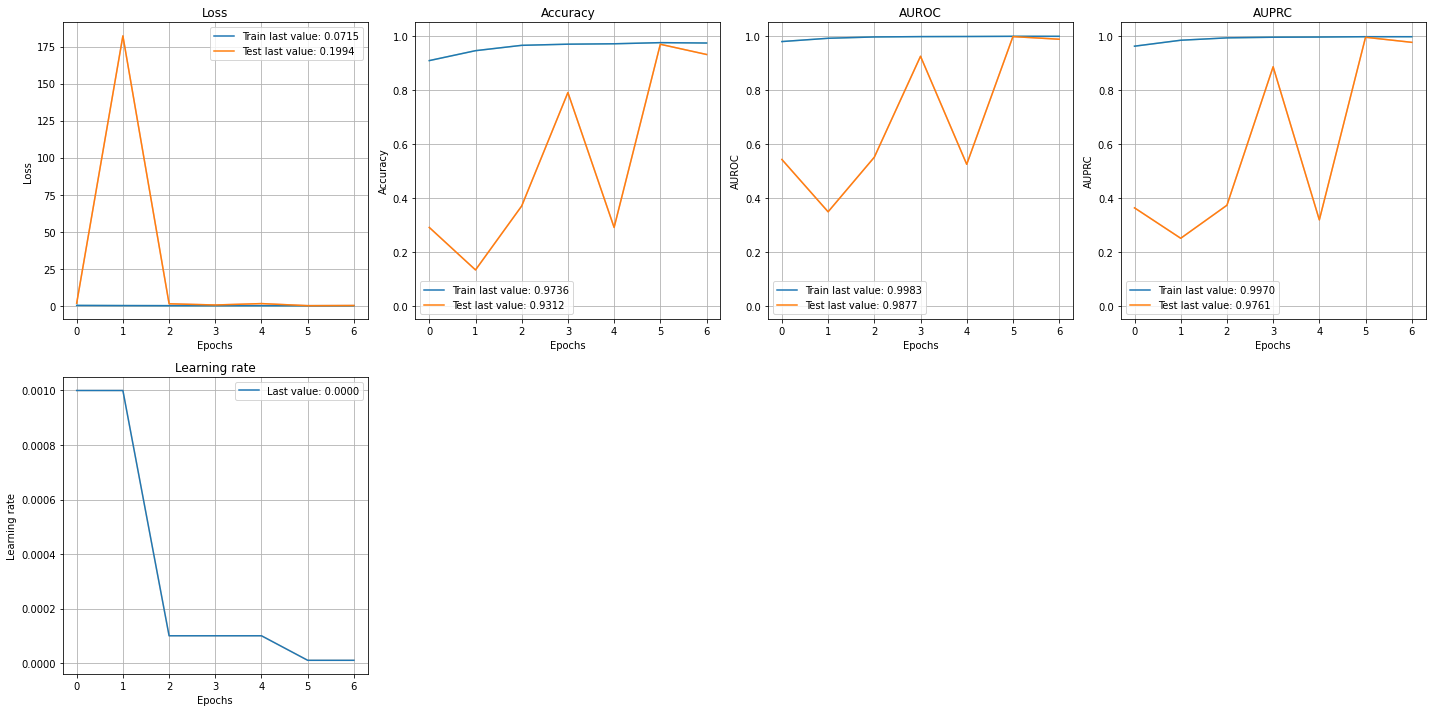

In [ ]:
for history in histories:
  plot_history(history)

**Results**

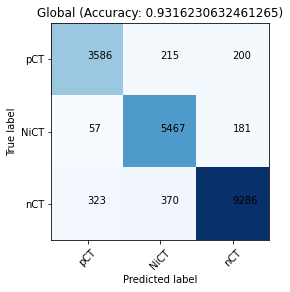

Recall micro:  0.9316230632461265
Recall macro:  0.9283707677833549
Recall weighted:  0.9316230632461265
Specificity micro:  0.9316230632461265
Specificity macro:  0.9227036276480626
Specificity weighted:  0.9325319593673674
F1 Score micro:  0.9316230632461265
F1 Score macro:  0.9251816376061699
F1 Score weighted:  0.9317180966980688
ROC AUC macro:  0.9466307045009646
ROC AUC micro:  0.9487172974345949


In [5]:
# Computing metrics

Y_all_pred = np.load('/content/drive/MyDrive/Y_all_pred.npy')

import matplotlib.pyplot as plt

def view_confusion_matrix(c, title):
  plt.clf()
  plt.imshow(c, interpolation='nearest', cmap=plt.cm.Blues)
  classNames = ['pCT', 'NiCT', 'nCT']
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  true=0
  all=0
  for i in range(3):
      for j in range(3):
          plt.text(j,i, str(c[i][j]))
          if i==j:
            true+=c[i][j]
          all+=c[i][j]
  title += ' (Accuracy: '+ str(true/all)+')'
  plt.title(title)
  plt.show()

view_confusion_matrix(confusion_matrix(Y_all, Y_all_pred), 'Global')

from sklearn.metrics import f1_score,confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score
print('Recall micro: ', recall_score(Y_all, Y_all_pred, average='micro'))
print('Recall macro: ', recall_score(Y_all, Y_all_pred, average='macro'))
print('Recall weighted: ', recall_score(Y_all, Y_all_pred, average='weighted'))
print('Specificity micro: ', precision_score(Y_all, Y_all_pred, average='micro'))
print('Specificity macro: ', precision_score(Y_all, Y_all_pred, average='macro'))
print('Specificity weighted: ', precision_score(Y_all, Y_all_pred, average='weighted'))
print('F1 Score micro: ', f1_score(Y_all, Y_all_pred, average='micro'))
print('F1 Score macro: ', f1_score(Y_all, Y_all_pred, average='macro'))
print('F1 Score weighted: ', f1_score(Y_all, Y_all_pred, average='weighted'))
print('ROC AUC macro: ', roc_auc_score(K.utils.to_categorical(Y_all), K.utils.to_categorical(Y_all_pred)))
print('ROC AUC micro: ', roc_auc_score(K.utils.to_categorical(Y_all), K.utils.to_categorical(Y_all_pred), average='micro'))

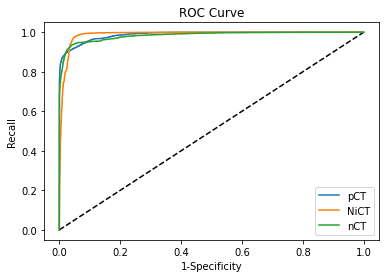

In [12]:
Y_pCT_true = []
Y_nCT_true = []
Y_NiCT_true = []

#pCT
for y in Y_all:
  if y == 0:
    Y_pCT_true.append(1)
  else:
    Y_pCT_true.append(0)

#NiCT
for y in Y_all:
  if y == 1:
    Y_NiCT_true.append(1)
  else:
    Y_NiCT_true.append(0)

#nCT
for y in Y_all:
  if y == 2:
    Y_nCT_true.append(1)
  else:
    Y_nCT_true.append(0)

from sklearn.metrics import f1_score,confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score
fpr1, tpr1, thresholds = roc_curve(Y_pCT_true, Y_pCT_pred)
fpr2, tpr2, thresholds = roc_curve(Y_NiCT_true, Y_NiCT_pred)
fpr3, tpr3, thresholds = roc_curve(Y_nCT_true, Y_nCT_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='pCT')
plt.plot(fpr2, tpr2, label='NiCT')
plt.plot(fpr3, tpr3, label='nCT')

plt.xlabel('1-Specificity')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.legend()
plt.show()